# Error Calculation
**Purpose**
    This notebook walks through the process of deriving and calculating the error for Elia's pertrubance system.

**System**
    Pertrubance system is two motors attached to a human through kevlar cables. While the human walks on a treadmill, the motors can apply forces, resulting in perturbations to the human's gait. 
    As the system is physically quite confined, even slight positional variation of the human relative to the static motors, result in potentially undesired force directions.
    This is evaluated here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.optimize as optimizer
from typing import Callable, Tuple, List

In [46]:
class ForceModel:
    def __init__(self, a, b, w):
        """Initialize with parameters of the setup.
        Args:
        -   a: float, distance a in sketch [m]
        -   b: float, distance b in sketch [m]
        -   w: float, waist [m]
        """
        self.a = a
        self.b = b
        self.w = w

        self.motor1_pos = np.array([a, b-w/2])
        self.motor2_pos = np.array([a, -b+w/2])

        self.gamma = np.arctan2(self.b - self.w/2, self.a)  # Angle of force vector from motor with respect to x-axis. Angle is positive for both motors!
    
    def f_desired_from_angle_and_magnitude(self, alpha: float, magnitude: float) -> np.ndarray:
        """From magnitude and angle alpha (defined relative to x-axis) the vector is returned.
        
        Args:
        -   angle: float, angle relative to x-axis in degrees
        -   magnitude: float, magnitude of the desired force vector in Newtons
        
        Returns:
        -   f_desired: np.ndarray of shape (2,), desired force vector [Fx, Fy]
        """
        # print(f"Converting {alpha}° to radians: {np.radians(alpha)}")
        alpha = np.radians(alpha)  # Convert angle to radians
        unit_vector = np.array([np.cos(alpha), np.sin(alpha)])

        return magnitude * unit_vector
    
    def error(self, f_desired: np.ndarray, f: np.ndarray) -> tuple[float, float]:
        """Calculates the error between desired and realized force vectors.
        Args:
        -   f_desired: np.ndarray of shape (2,), desired force vector [Fx, Fy]
        -   f: np.ndarray of shape (2,), realized force vector [Fx, Fy] (considering delta a and delta b)
        
        Returns:
        -   angle_error: float, angle error in degrees
        -   magnitude_error: float, magnitude error in Newtons
        """
        f_desired_norm = np.linalg.norm(f_desired)
        f_norm = np.linalg.norm(f)

        if f_desired_norm == 0 or f_norm == 0:
            return 0.0, 0.0

        # Angle error. (Alpha is the angle of the force vector with respect to the x-axis)
        alpha_desired = np.arctan2(f_desired[1], f_desired[0])
        alpha = np.arctan2(f[1], f[0])
        angle_error = np.degrees(alpha - alpha_desired)

        # Magnitude error
        magnitude_error = np.linalg.norm(f - f_desired)

        return angle_error, magnitude_error

    def motor_forces(self, f_desired: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """For a given desired force, this function returns the forces applied by each motor.
        The returning forces are returned as magnitudes.

        Details:
        When we give the system a desired force vector f_desired, then we assume that the position of the human is at the origin (0, 0).
        From this assumption, we can calculate the forces each motor needs to apply to get the resulting force vector f_desired.
        This function returns the magnitudes of the forces of each motor.
        
        Args:
        -   f_desired: np.ndarray of shape (2,), desired force vector [Fx, Fy]
        
        Returns:
        -   f1: float, force applied by motor 1
        -   f2: float, force applied by motor 2
        """
        f_desired_mag = np.linalg.norm(f_desired)
        alpha_desired = np.arctan2(f_desired[1], f_desired[0])  # Math: arctan2(y-coordinate / x-coordinate) = angle

        # Calculate f1 and f2 magnitudes using linear system of equations. Math is outlined in description.
        f1 = 1/2 * f_desired_mag * ( (np.cos(alpha_desired)/np.cos(self.gamma)) + (np.sin(alpha_desired)/np.sin(self.gamma)) )
        f2 = 1/2 * f_desired_mag * ( (np.cos(alpha_desired)/np.cos(self.gamma)) - (np.sin(alpha_desired)/np.sin(self.gamma)) )

        return f1, f2
    
    def f(self, f1: float, f2: float, delta_a: float = 0.0, delta_b: float = 0.0) -> np.ndarray:
        """For two given motor forces, this function returns the resulting force vector, 
        considering positional errors of delta_a and delta_b.
        The errors given by delta_a and delta_b are the positional error of the human, which should be standing at
        the origin in (0,0) position.

        Example:
        If we assume the human has a positional error of 10cm in x and 5cm in y, we pass delta_a = 0.1 and delta_b = 0.05.
        
        Args:
        -   f1: float, the force magnitude applied by motor 1
        -   f2: float, the force magnitude applied by motor 2
        -   delta_a: float, positional error of human in x-direction [m]
        -   delta_b: float, positional error of human in y-direction [m]
        
        Returns:
        -   f: np.ndarray of shape (2,), resulting force applied to the human considering positional errors."""
        # get unit vectors from human to motors:
        to_motor1 = self.motor1_pos - np.array([delta_a, delta_b])
        to_motor2 = self.motor2_pos - np.array([delta_a, delta_b])

        f = f1 * to_motor1/np.linalg.norm(to_motor1) + \
            f2 * to_motor2/np.linalg.norm(to_motor2)

        return f


    def loss_function(self, f_desired_magnitude: float, alpha_desired: float, delta_a: float, delta_b: float) -> float:
        f_desired = self.f_desired_from_angle_and_magnitude(alpha=alpha_desired, magnitude=f_desired_magnitude)
        f1, f2 = self.motor_forces(f_desired)
        f = self.f(f1, f2, delta_a, delta_b)

        angle_error, magnitude_error = self.error(f_desired, f)

        return -abs(angle_error), -abs(magnitude_error), -abs(angle_error) - abs(magnitude_error)


#### Optimization

In [47]:
def maximize_error(model: ForceModel, f_desired_magnitude: float, delta_alpha: float, delta_a: float, delta_b: float, 
                   loss: str = 'combined', silent: bool = False) -> optimizer.OptimizeResult:
    """Maximizes the error by minimizing the negative of the loss function."""
    # Define the objective function to minimize
    def objective_function(vars):
        alpha, delta_a, delta_b = vars
        if loss == 'angle':
            index = 0
        elif loss == 'magnitude':
            index = 1
        elif loss == 'combined':
            index = 2
        return model.loss_function(f_desired_magnitude, alpha, delta_a, delta_b)[index]

    # Initial guess for optimization
    initial_guess = [delta_alpha/2, 0.0, 0.0]

    # Define bounds for the variables
    bounds = [(-delta_alpha, delta_alpha), (-delta_a, delta_a), (-delta_b, delta_b)]

    # Constraints
    constraints = [
        {'type': 'ineq', 'fun': lambda x: x[0] - (-delta_alpha)},  # alpha >= -delta_alpha
        {'type': 'ineq', 'fun': lambda x: delta_alpha - x[0]},      # alpha <= delta_alpha
        {'type': 'ineq', 'fun': lambda x: x[1] - (-delta_a)},       # delta_a >= -delta_a
        {'type': 'ineq', 'fun': lambda x: delta_a - x[1]},          # delta_a <= delta_a
        {'type': 'ineq', 'fun': lambda x: x[2] - (-delta_b)},       # delta_b >= -delta_b
        {'type': 'ineq', 'fun': lambda x: delta_b - x[2]},          # delta_b <= delta_b
    ]

    # Perform optimization
    result = optimizer.minimize(objective_function, initial_guess, bounds=bounds, constraints=constraints, method='SLSQP')

    if not silent:
        print(f"Optimizaiton has been successful: {result.success}")
        print(f"""Optimal values found:
            \n    alpha: {result.x[0]:.2f}°       with bounds (-{delta_alpha}, {delta_alpha})°
            \n    delta_a: {result.x[1]:.2f} m    with bounds (-{delta_a}, {delta_a}) m
            \n    delta_b: {result.x[2]:.2f} m    with bounds (-{delta_b}, {delta_b}) m""")

    return result

#### Plotting Functions

In [48]:
def max_error(model: ForceModel, f_desired_magnitude: float, alpha_range: tuple, delta_a_range: tuple, delta_b_range: tuple) -> None:
    """For the space spanned by delta_a and delta_b, the optimization is performed and the negative result is plotted."""
    a = np.linspace(delta_a_range[0], delta_a_range[1], 50)
    b = np.linspace(delta_b_range[0], delta_b_range[1], 50)

    A, B = np.meshgrid(a, b)
    Z_angle = np.zeros_like(A)
    Z_magnitude = np.zeros_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            result = maximize_error(model, f_desired_magnitude, alpha_range[1], A[i, j], B[i, j], loss='angle', silent=True)
            Z_angle[i, j] = -result.fun  # Store the negative of the objective function value

            result = maximize_error(model, f_desired_magnitude, alpha_range[1], A[i, j], B[i, j], loss='magnitude', silent=True)
            Z_magnitude[i, j] = -result.fun  # Store the negative of the objective function value

    plt.figure(figsize=(10, 6))
    plt.contourf(A, B, Z_angle, levels=50, cmap='viridis')
    plt.colorbar(label='Maximum Angle-Error for ΔA and ΔB')
    plt.title('Maximized Error Heatmap')
    plt.xlabel('ΔA (m)')
    plt.ylabel('ΔB (m)')
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.show()

def error_for_const_offset(model: ForceModel, f_desired_magnitude: float, alpha_range: tuple, delta_a_fixed: float, delta_b_fixed: float) -> None:
    """For a given offset (choose worst-case for delta_a and delta_b), we make two side-by-side plots of the desired and resulting angle and force respectively."""
    alpha = np.linspace(alpha_range[0], alpha_range[1], 50)

    angle_error = np.zeros_like(alpha)
    magnitude_error = np.zeros_like(alpha)
    for i in range(alpha.shape[0]):
        angle_error[i], magnitude_error[i], _ = model.loss_function(f_desired_magnitude, alpha[i], delta_a_fixed, delta_b_fixed)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(alpha, -angle_error, label='Angle Error [°]', color='blue')
    axs[0].set_title('Absolute Angle Error for Varying Alpha')
    axs[0].set_xlabel('Alpha desired [°]')
    axs[0].set_ylabel('Absolute Angle Error [°]') 
    axs[0].grid()
    axs[0].axhline(0, color='black', lw=0.5, ls='--')
    axs[0].legend()

    axs[1].plot(alpha, -magnitude_error, label='Magnitude Error [N]', color='orange')
    axs[1].set_title('Magnitude Error for Varying Alpha')
    axs[1].set_xlabel('Alpha desired [°]')
    axs[1].set_ylabel('Magnitude Error [N]')
    axs[1].grid()
    axs[1].axhline(0, color='black', lw=0.5, ls='--')
    axs[1].legend()

def heatmap(model: ForceModel, f_desired_magnitude: float, alpha_desired: float, delta_a_range: tuple, delta_b_range: tuple, bounding_box: tuple) -> None:
    """Creates a heatmap of the error ('angle' and 'magnitude') for varying delta_a and delta_b."""
    a = np.linspace(delta_a_range[0], delta_a_range[1], 100)
    b = np.linspace(delta_b_range[0], delta_b_range[1], 100)

    A, B = np.meshgrid(a, b)
    Z_angle = np.zeros_like(A)
    Z_magnitude = np.zeros_like(A)

    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            Z_angle[i, j], Z_magnitude[i, j], _ = model.loss_function(f_desired_magnitude, alpha_desired, A[i, j], B[i, j])
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    c1 = axs[0].contourf(A, B, -Z_angle, levels=50, cmap='viridis')
    axs[0].set_title('Absolute Angle Error')
    axs[0].set_xlabel('ΔA (m)')
    axs[0].set_ylabel('ΔB (m)')
    axs[0].set_aspect('equal')
    fig.colorbar(c1, ax=axs[0], label='Angle Error (degrees)')

    # Draw bounding box in heatmap given by bounding_box
    rect = patches.Rectangle((-bounding_box[0], -bounding_box[1]),
                             2 * bounding_box[0], 2 * bounding_box[1],
                             linewidth=1, edgecolor='red', facecolor='none', linestyle='--', label='Maximum expected error')
    axs[0].add_patch(rect)
    axs[0].legend()

    c2 = axs[1].contourf(A, B, -Z_magnitude, levels=50, cmap='plasma')
    axs[1].set_title('Absolute Magnitude Error')
    axs[1].set_xlabel('ΔA (m)')
    axs[1].set_ylabel('ΔB (m)')
    axs[1].set_aspect('equal')
    fig.colorbar(c2, ax=axs[1], label='Magnitude Error (N)')
    # Draw bounding box in heatmap given by bounding_box
    rect = patches.Rectangle((-bounding_box[0], -bounding_box[1]),
                             2 * bounding_box[0], 2 * bounding_box[1],
                             linewidth=1, edgecolor='red', facecolor='none', linestyle='--', label='Maximum expected error')
    axs[1].add_patch(rect)
    axs[1].legend()

    plt.suptitle('Expected Error for varing ΔA and ΔB')
    plt.tight_layout()
    plt.show()


def plot_vectors(model: ForceModel, f_desired: np.ndarray, delta_a: float, delta_b: float):
        """Creates a plot which includes; position of human, motors, desired force vector and the applied force vector.
        All errors are calculated and printed.
        
        Args:
        -   f_desired: np.ndarray of shape (2,), desired force vector [Fx, Fy]
        -   delta_a: float, positional error of human in x-direction [m]
        -   delta_b: float, positional error of human in y-direction [m]
        """
        # Using f_desired, get forces f1 and f2 applied by the motors
        f1, f2 = model.motor_forces(f_desired)
        # Calculate the resulting force vector f considering the positional errors delta_a and delta_b
        f = model.f(f1, f2, delta_a, delta_b)
        # Calculate errors between f_desired and f
        angle_error, magnitude_error = model.error(f_desired, f)

        # Angles to be displayed
        alpha_desired = np.degrees(np.arctan2(f_desired[1], f_desired[0]))
        alpha = np.degrees(np.arctan2(f[1], f[0]))

        # --- Plotting ---
        plt.figure(figsize=(8, 6))

        # Plot dotted lines from human position to motors
        plt.plot([delta_a, model.motor1_pos[0]], [delta_b, model.motor1_pos[1]], linestyle='--', color='grey', markersize='10', alpha=0.3)
        plt.plot([delta_a, model.motor2_pos[0]], [delta_b, model.motor2_pos[1]], linestyle='--', color='grey', markersize='10', alpha=0.3)

        # Plot motor positions
        plt.plot(model.motor1_pos[0], model.motor1_pos[1], marker='s', color='darkblue', linestyle='', markersize=10, label='Motor 1')
        plt.plot(model.motor2_pos[0], model.motor2_pos[1], marker='s', color='blue', linestyle='', markersize=10, label='Motor 2')

        # Plot human position
        plt.plot(delta_a, delta_b, marker='>', color='brown', markersize=15, linestyle='', label='Human Position (with error)')

        # Plot vector from origin to human position
        plt.plot([0, delta_a], [0, delta_b], color='brown', linestyle='--', alpha=0.5, label=f'Error Vector: [{np.round(delta_a, 2)}, {np.round(delta_b, 2)}]')

        # Desired force vector
        plt.quiver(delta_a, delta_b, f_desired[0], f_desired[1],
                    angles='xy', scale_units='xy', scale=1, width=0.001, color='tan')
        plt.quiver(delta_a, delta_b, f_desired[0], f_desired[1],
                   angles='xy', scale_units='xy', scale=150, width=0.008, color='tan', label='Desired Force Vector')
        
        # Applied force vector
        plt.quiver(delta_a, delta_b, f[0], f[1],
                   angles='xy', scale_units='xy', scale=1, width=0.001, color='orange')
        plt.quiver(delta_a, delta_b, f[0], f[1],
                   angles='xy', scale_units='xy', scale=150, width=0.008, color='orange', label='Applied Force Vector')

        # Add curved angle arrows
        def add_angle_arc(center, angle_deg, radius=0.15, color='tan', alpha=0.7, linestyle='-'):
            """Add a curved arc to show angle from x-axis"""
            if abs(angle_deg) < 1:  # Skip very small angles
                return
                
            # Create arc from 0 to angle_deg
            start_angle = 0
            end_angle = angle_deg
            
            if angle_deg < 0:
                start_angle = angle_deg
                end_angle = 0
                
            arc = patches.Arc(center, 2*radius, 2*radius, 
                            angle=0, theta1=start_angle, theta2=end_angle,
                            color=color, alpha=alpha, linestyle=linestyle, linewidth=1.5)
            plt.gca().add_patch(arc)
            
            # Add arrow at the end of arc
            arrow_angle = np.radians(end_angle)
            arrow_x = center[0] + radius * np.cos(arrow_angle)
            arrow_y = center[1] + radius * np.sin(arrow_angle)
            
            # Calculate arrow direction (tangent to arc)
            if angle_deg > 0:
                arrow_dx = -0.02 * np.sin(arrow_angle)
                arrow_dy = 0.02 * np.cos(arrow_angle)
            else:
                arrow_dx = 0.02 * np.sin(arrow_angle)
                arrow_dy = -0.02 * np.cos(arrow_angle)
                
            # plt.annotate('', xy=(arrow_x + arrow_dx, arrow_y + arrow_dy), 
            #             xytext=(arrow_x, arrow_y),
            #             arrowprops=dict(arrowstyle='->', color=color, alpha=alpha, lw=1))
        
        # Add angle arcs for both vectors
        arc_radius = 0.09
        add_angle_arc((delta_a, delta_b), alpha_desired, radius=arc_radius*4, color='tan')
        add_angle_arc((delta_a, delta_b), alpha, radius=arc_radius*3, color='orange')
        
        # Add reference x-axis line from human position
        # ref_length = 0.2
        # plt.plot([delta_a, delta_a + ref_length], [delta_b, delta_b], 
        #         color='black', linestyle=':', alpha=0.5, linewidth=1)
        
        # Add angle text annotations
        text_radius = arc_radius + 0.05
        
        # Desired angle text
        text_angle_desired = np.radians(alpha_desired)
        text_x_desired = delta_a + (arc_radius*4+0.05) * np.cos(text_angle_desired/2)
        text_y_desired = delta_b + (arc_radius*4+0.05) * np.sin(text_angle_desired/2)
        plt.annotate(f'{alpha_desired:.1f}°', 
                    xy=(text_x_desired, text_y_desired),
                    fontsize=9, color='tan', weight='bold',
                    ha='center', va='center')
        
        # Actual angle text
        text_angle_actual = np.radians(alpha)
        text_x_actual = delta_a + (arc_radius*3 + 0.035) * np.cos(text_angle_actual/2)
        text_y_actual = delta_b + (arc_radius*3 + 0.035) * np.sin(text_angle_actual/2)
        plt.annotate(f'{alpha:.1f}°', 
                    xy=(text_x_actual, text_y_actual),
                    fontsize=9, color='orange', weight='bold',
                    ha='center', va='center')
        # plt.hline(y=0, color='bue', linestyle='-', linewidth=0.5, alpha=0.5)
        plt.axhline(0, color='gray', lw=0.5, ls='--')
        plt.axvline(0, color='gray', lw=0.5, ls='--')
        plt.title('Applied Force and Desired Force')
        plt.xlabel('X Position (m)')
        plt.ylabel('Y Position (m)')
        plt.grid()
        plt.legend()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

## Setup

In [57]:
f_desired_magnitude = 50
alpha_desired = 20        # Angle bounds go from (-alpha_desired, alpha_desired) in degrees.
delta_a = 0.1            # Error bounds in x-direction in meters.
delta_b = 0.2            # Error bounds in y-direction in meters.

model = ForceModel(a=0.65, b=0.45, w=0.35)

### Optimizer
Following, the package `scipy.optimize` is used to find the worst-case error.
The optimizer optimizes over bounds of:
- `[-delta_a, delta_a]` : error of human position in x-direction
- `[-delta_b, delta_b]` : error of human position in y-direction
- `[-alpha_desired, alpha_desired]` : different desired angle of resulting force



The loss functions are:

- `'angle'`: abs(alpha - alpha_desired)
- `'magnitude'`: abs(magnitude - magnitude_desired)  
- `'combined'`: abs(angle_error) + abs(magnitude_error)


_(The implementation of the optimiziation is a minimizer, hence we return the negative error to find the maximum error.)_

In [58]:
# Example usage
result = maximize_error(model, 
                        f_desired_magnitude,
                        delta_alpha=alpha_desired,
                        delta_a=delta_a, 
                        delta_b=delta_b,
                        loss='combined')  # 'angle', 'magnitude' or 'combined'

Optimizaiton has been successful: True
Optimal values found:
            
    alpha: -20.00°       with bounds (-20, 20)°
            
    delta_a: 0.10 m    with bounds (-0.1, 0.1) m
            
    delta_b: 0.20 m    with bounds (-0.2, 0.2) m


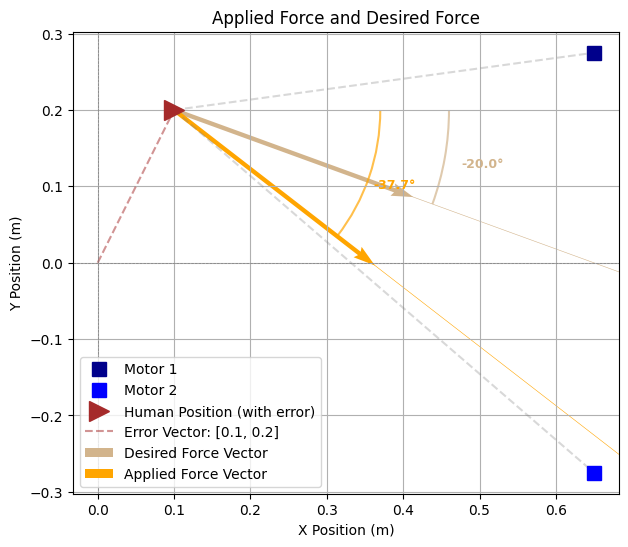

In [59]:
plot_vectors(model,
             f_desired=model.f_desired_from_angle_and_magnitude(result.x[0], f_desired_magnitude),
             delta_a=result.x[1],
             delta_b=result.x[2]
             )

## Visualization of worst-case error

Maximize error for a grid of `delta_a` and `delta_b` values.

Attention: This cell takes a long time to run! (~40seconds)

c:\Users\maxgr\Documents\GIT\PertrubanceError\.venv\Lib\site-packages\scipy\optimize\_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
c:\Users\maxgr\Documents\GIT\PertrubanceError\.venv\Lib\site-packages\scipy\optimize\_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
c:\Users\maxgr\Documents\GIT\PertrubanceError\.venv\Lib\site-packages\scipy\optimize\_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


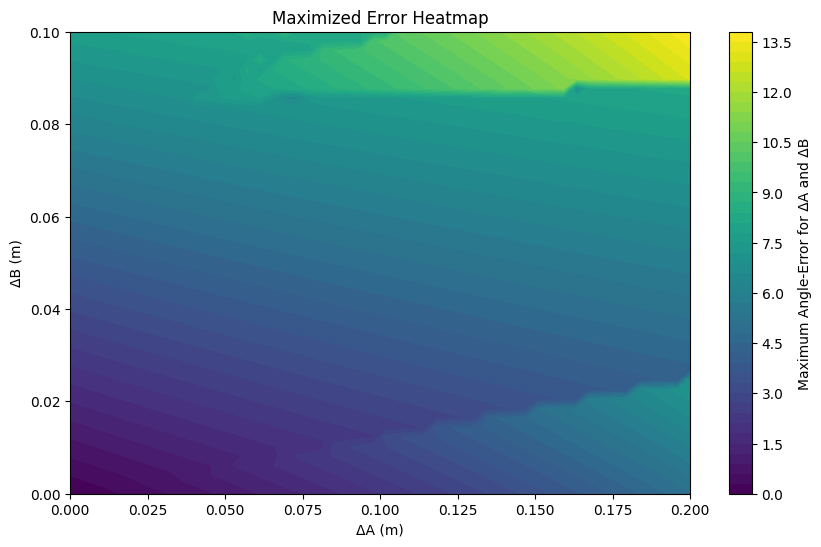

In [19]:
max_error(model, f_desired_magnitude, 
          alpha_range=(-alpha_desired, alpha_desired), 
          delta_a_range=(0, 0.2), 
          delta_b_range=(0, 0.1))

### Error
Worst-case is when:
- `delta_a` is at its maximum
- `delta_b` is at its maximum
- `alpha_desired` is at its maximum

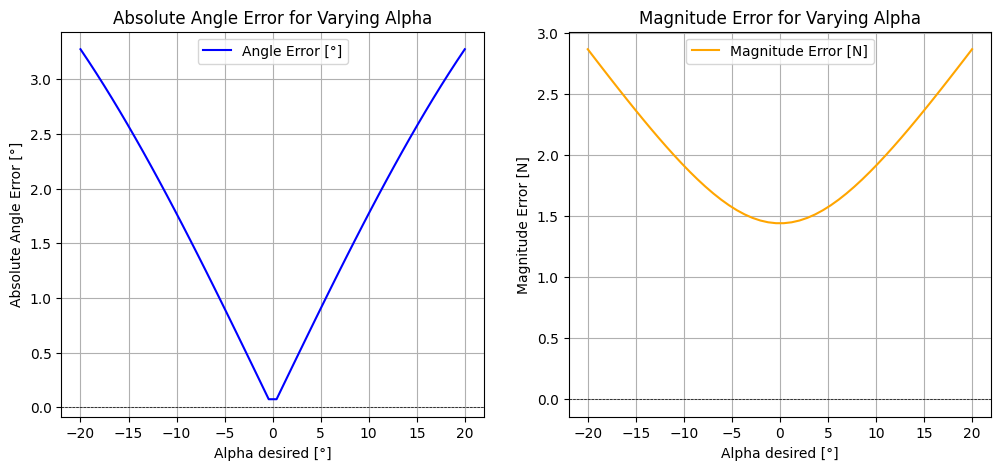

In [55]:
error_for_const_offset(model,
                       f_desired_magnitude,
                       alpha_range=(-alpha_desired, alpha_desired),
                       delta_a_fixed=0.1,
                       delta_b_fixed=0.0)

### Heatmap
For the most extreme case (see section above), we make a heatmap for varying precision in human position, given by `delta_a` and `delta_b`. For this, we fix the desired angle to the maximum value.

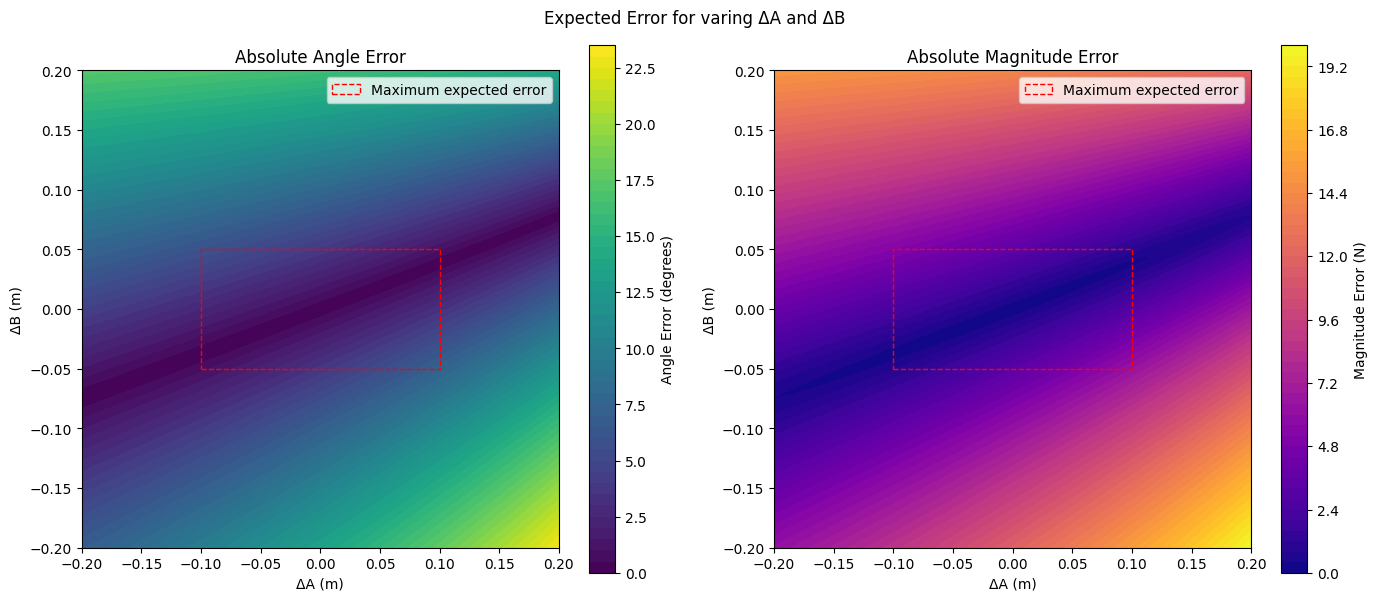

In [56]:
heatmap(model, 
       f_desired_magnitude, 
       alpha_desired=alpha_desired, # Choose largest alpha which you will be using.
       delta_a_range=(-0.2, 0.2), 
       delta_b_range=(-0.2, 0.2), 
       bounding_box=(0.1, 0.05))  # Bounding box for expected error limits (red box)